In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import bayesflow as bf
from bayesflow.benchmarks import Benchmark

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

/Users/marvin/miniforge3/envs/cmpe/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Generative model
We move on to the TwoMoons example.

In [2]:
class Simulator:
    """A two-moons simulator that avoids problems due to bounded priors."""

    def __init__(self):
        self.prior = tfd.Independent(
            tfd.Uniform(low=[-1, -1], high=[1., 1.]),
            reinterpreted_batch_ndims=1
        )
        self.tm = Benchmark('two_moons')

    def __call__(self, batch_size):        
        draws = self.prior.sample(batch_size).numpy()
        sims = self.tm.generative_model.simulator(draws)
        return {
            'sim_data': sims['sim_data'].astype(np.float32), 
            'prior_draws': draws.astype(np.float32)
        }

    def sample_given_params(self, params):
        sims = self.tm.generative_model.simulator(params)
        sims = sims['sim_data'].astype(np.float32)
        return sims

### Configurator

In [3]:
@tf.function
def configurator(input_dict):
    return {
        'parameters': input_dict['prior_draws'],
        'direct_conditions': input_dict['sim_data']
    }

### New amortizer (SNPE-C)

In [4]:
class ContrastiveAmortizer(bf.amortizers.AmortizedPosterior):
    """Creates a non-amoritzed estimator for SNPE-C using contrastive learning."""

    def compute_loss(self, input_dict, **kwargs):
        """
        Follows the contrastive learnign generalization of SNPE-C [1].
        
        [1] Durkan, C., Murray, I., & Papamakarios, G. (2020, November). 
        On contrastive learning for likelihood-free inference. 
        In International conference on machine learning (pp. 2771-2781). PMLR.
        """

        if self.first_round:
            return self._maximum_likelihood(input_dict, **kwargs)
        return self._contrastive(input_dict, **kwargs)

    def _maximum_likelihood(self, input_dict, **kwargs):

        # Pre-compute condition / summaries
        _, conditions = self._compute_summary_condition(
            input_dict.get("summary_conditions"),
            input_dict.get("direct_conditions"),
            **kwargs,
        )

        # Numerator quantities
        z, log_det_J = self.inference_net.forward(
            input_dict["parameters"], conditions, **kwargs
        )
        post_lpdf = self.latent_dist.log_prob(z) + log_det_J
        return -tf.reduce_mean(post_lpdf)

    def _contrastive(self, input_dict, **kwargs):

        # Get batch size
        B = tf.shape(input_dict['parameters'])[0]

        # Pre-compute condition / summaries
        _, conditions = self._compute_summary_condition(
            input_dict.get("summary_conditions"),
            input_dict.get("direct_conditions"),
            **kwargs,
        )

        # Numerator quantities
        z, log_det_J = self.inference_net.forward(
            input_dict["parameters"], conditions, **kwargs
        )
        post_lpdf = self.latent_dist.log_prob(z) + log_det_J
        prior_lpdf = self.prior.log_prob(input_dict['parameters'])
        log_ratios = post_lpdf - prior_lpdf

        # Denominator quantities (contrastive pairs)
        rep_params = tf.reshape(tf.tile(input_dict['parameters'], (B, 1)), (B, B, -1))
        z, log_det_J = self.inference_net.forward(
            rep_params, conditions, **kwargs
        )
        post_lpdf_c = self.latent_dist.log_prob(z) + log_det_J
        prior_lpdf_c = self.prior.log_prob(rep_params)
        log_ratios_c = post_lpdf_c - prior_lpdf_c

        # Get rid of diagonal elements (self-ratios)
        log_ratios_c = tf.boolean_mask(log_ratios_c, ~tf.eye(B, dtype=tf.bool))
        log_ratios_c = tf.reshape(log_ratios_c, (B, B-1))

        # Do a little hack for excluding the self-ratios
        logsumexp_c = tf.reduce_logsumexp(log_ratios_c, axis=1)
        loss = -tf.reduce_mean(log_ratios - logsumexp_c)
        return loss

### Utility-function for round-based training

In [5]:
def train_rounds(
        trainer, 
        simulator,
        optimizer, 
        obs_data,
        rounds=5,
        epochs_per_round=10,
        simulations_per_round=1000, 
        batch_size=128
    ):

    # Inits and first round
    dataset = simulator(simulations_per_round)
    round_histories = []

    # First round does ML and discards samples
    h = trainer.train_offline(
            simulations_dict=dataset, 
            batch_size=batch_size, 
            epochs=epochs_per_round, 
            optimizer=optimizer, 
            reuse_optimizer=True
    )
    round_histories.append(h)
    trainer.amortizer.first_round = False

    # Round-based training (r = 2,...,rounds)
    for r in range(2, rounds):

        # Sample parameters from current proposal and simulate new data
        new_parameters = trainer.amortizer.sample(obs_data, n_samples=simulations_per_round)

        # Reject OOB
        mask = tf.math.is_finite(simulator.prior.log_prob(new_parameters)).numpy()
        new_parameters = new_parameters[mask]
        print(f'Round {r}, Rejected #: {(~mask).sum()}')
        new_data = simulator.sample_given_params(new_parameters)
        
        # Second round simply collects the data 
        if r == 2:
            dataset = {
                'prior_draws': new_parameters, 
                'sim_data': new_data
            }
        else:
            dataset = {
                'prior_draws': tf.concat([dataset['prior_draws'], new_parameters], axis=0),
                'sim_data': tf.concat([dataset['sim_data'], new_data], axis=0),
            }

        # Train and store history
        h = trainer.train_offline(
            simulations_dict=dataset, 
            batch_size=batch_size, 
            epochs=epochs_per_round, 
            optimizer=optimizer, 
            reuse_optimizer=True
        )
        round_histories.append(h)

    trainer.amortizer.first_round = True   
    return round_histories

### Round-based sequential training

In [6]:
# Create custom simulator
simulator = Simulator()

# New amortizer + nasty hack to add attribute
amortizer = ContrastiveAmortizer(
    inference_net=bf.networks.InvertibleNetwork(
        num_params=2, num_coupling_layers=5
    ),
    latent_dist=tfd.MultivariateStudentTLinearOperator(
        df=50, loc=[0., 0.], scale=tf.linalg.LinearOperatorDiag([1.0] * 2)
    )
)
amortizer.first_round = True
amortizer.prior = simulator.prior

# Trainer definition with an identity config
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=simulator,
    configurator=configurator
)

# Further training hyperparameters
train_config = {
    'rounds': 5,
    'simulations_per_round': 2000,
    'epochs_per_round': 30,
    'batch_size': 64, 
}

# Shared optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4, clipnorm=1.0
)

# The data to perform inference on
obs_data = {'direct_conditions': np.zeros((1, 2)).astype(np.float32)}

INFO:root:Performing 2 pilot runs with the two_moons model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [7]:
histories = train_rounds(trainer, simulator, optimizer, obs_data, **train_config)

Training epoch 30: 100%|██████████| 32/32 [00:00<00:00, 80.50it/s, Epoch: 30, Batch: 32,Loss: -2.059,W.Decay: 0.245,Avg.Loss: -1.965,Avg.W.Decay: 0.245,LR: 1.00E-04]


Round 2, Rejected #: 0


Training epoch 30: 100%|██████████| 32/32 [00:03<00:00, 10.58it/s, Epoch: 30, Batch: 32,Loss: 0.845,W.Decay: 0.239,Avg.Loss: 2.569,Avg.W.Decay: 0.239,LR: 1.00E-04]


Round 3, Rejected #: 0


Training epoch 10:  68%|██████▊   | 43/63 [00:04<00:01, 11.07it/s, Epoch: 10, Batch: 43,Loss: 2.111,W.Decay: 0.236,Avg.Loss: 2.361,Avg.W.Decay: 0.236,LR: 1.00E-04]

### Validation
Quick and dirty, nothing super sophisticated.

AttributeError: module 'seaborn' has no attribute 'grid'

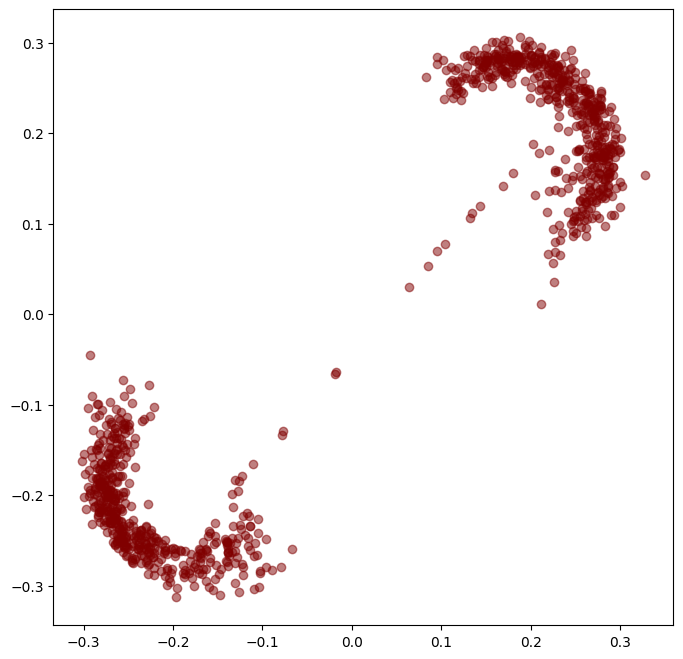

In [ ]:
post_samples = amortizer.sample(obs_data, n_samples=1000)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(post_samples[:, 0], post_samples[:, 1], color='maroon', alpha=0.5)
ax.grid(alpha=0.1)